In [3]:
# I am interested in figuring out what factors might impact a cats's chances of getting adopted (vs other outcomes)
# I'm working from a dataset of intakes and outcomes from a shelter in Texas (Austin Animal Center)
# I have previously cleaned this data, so I don't need to worry about duplicates, nulls, basic quality controls, etc. 
# My goal is to identify specific features I might use to model/predict a cat's chance of adoption. 

# Right away, I have some suspicions about what might make a cat more or less adoptable: age, appearance, sex, intake condition, and possibly the intake time (busy seasons)

In [4]:
import numpy as np
import pandas as pd
#import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from ydata_profiling import ProfileReport
from scipy.stats.contingency import crosstab
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import re
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours

In [5]:
# Import data
data = pd.read_csv('Intake and Outcome Data - Austin Animal Center.csv')
data = data.iloc[:,1:]
data.head()

Animal ID Animal Type Date of Birth      Sex                         Breed  \
0   A521520         Dog    09/07/2006   Female  Border Terrier/Border Collie   
1   A664235         Cat    09/24/2013  Unknown        Domestic Shorthair Mix   
2   A664237         Cat    09/24/2013  Unknown        Domestic Shorthair Mix   
3   A664236         Cat    09/24/2013  Unknown        Domestic Shorthair Mix   
4   A664233         Dog    09/30/2010   Female                  Pit Bull Mix   

          Color Intake Type Intake Condition  Intake Age  \
0     White/Tan       Stray           Normal        2555   
1  Orange/White       Stray           Normal           7   
2  Orange/White       Stray           Normal           7   
3  Orange/White       Stray           Normal           7   
4    Blue/White       Stray          Injured        1095   

  Intake Reproductive Status      Intake DateTime     Outcome DateTime  \
0                    Altered  2013-10-01 07:51:00  2013-10-01 15:39:00   
1                    Unknown  2013-10-01 08:33:00  2013-10-01 10:39:00   
2                    Unknown  2013-10-01 08:33:00  2013-10-01 10:44:00   
3                    Unknown  2013-10-01 08:33:00  2013-10-01 10:44:00   
4                     Intact  2013-10-01 08:53:00  2013-10-01 15:33:00   

      Outcome Type Outcome Subtype  Outcome Age Outcome Reproductive Status  
0  Return to Owner   Not Specified         2555                     Altered  
1         Transfer         Partner            7                     Unknown  
2         Transfer         Partner            7                     Unknown  
3         Transfer         Partner            7                     Unknown  
4       Euthanasia       Suffering         1095                      Intact

In [6]:
# Converting strings to numerical values
data['Intake DateTime'] = pd.to_datetime(data['Intake DateTime'], format = '%Y-%m-%d %H:%M:%S')
data['Outcome DateTime'] = pd.to_datetime(data['Outcome DateTime'], format = '%Y-%m-%d %H:%M:%S')
data['Date of Birth'] = pd.to_datetime(data['Date of Birth'], format = '%m/%d/%Y')

In [7]:
# I expect that the factors that impact a dog's chances of adoption might differ than those of a cat, livestock, or exotic animal.
# I'm focusing on cats in this exploration, so I don't need to continue with all the other species' data. 

#dogs = data.loc[data['Animal Type'] == 'Dog']
#bird = data.loc[data['Animal Type'] == 'Bird']
#livestock = data.loc[data['Animal Type'] == 'Livestock'] #this dataset is pretty small - only about 30 animals, so barely enough data to interpret!
#exotics = data.loc[data['Animal Type'] == 'Other']

cats = data.loc[data['Animal Type'] == 'Cat']
cats['Outcome Type'].unique()

array(['Transfer', 'Euthanasia', 'Adoption', 'Died', 'Return to Owner',
       'Missing', 'Disposal', 'Rto-Adopt', 'Relocate', 'Lost'],
      dtype=object)

#### Feature Consolidation

In [8]:
# Pet's with presenting as Euthanasia Request will never be adopted out, so these won't answer my question in a meaningful way. 
# So I will get rid of that intake type
# Same for Lost and Missing as outcome types; these aren't intentional outcomes, so they won't answer my question meaningfully (and are hopefully infrequent)

cats = cats.loc[(cats['Intake Type'] != 'Euthanasia Request') &
                ((cats['Outcome Type'] != 'Lost') &
                (cats['Outcome Type'] != 'Missing') )]


In [9]:
# Function to calculate the Duration of Stay in days
def calculate_stay(row):
    timedelta = row['Outcome DateTime'] - row['Intake DateTime']
    return timedelta.days

In [10]:
# Feature Engineering - I'd also like to track the length of stay in the shelter to see if the variables associated with adoption outcome also change how long it takes a pet to be adopted. 

cats['Duration of Stay'] = cats.apply(calculate_stay, axis = 1)
cats.head()

Animal ID Animal Type Date of Birth      Sex                   Breed  \
1   A664235         Cat    2013-09-24  Unknown  Domestic Shorthair Mix   
2   A664237         Cat    2013-09-24  Unknown  Domestic Shorthair Mix   
3   A664236         Cat    2013-09-24  Unknown  Domestic Shorthair Mix   
5   A664238         Cat    2013-06-01  Unknown  American Shorthair Mix   
7   A664256         Cat    1996-10-01     Male  Domestic Shorthair Mix   

               Color      Intake Type Intake Condition  Intake Age  \
1       Orange/White            Stray           Normal           7   
2       Orange/White            Stray           Normal           7   
3       Orange/White            Stray           Normal           7   
5        Black/White            Stray           Normal         120   
7  Brown Tabby/White  Owner Surrender           Normal        6205   

  Intake Reproductive Status     Intake DateTime    Outcome DateTime  \
1                    Unknown 2013-10-01 08:33:00 2013-10-01 10:39:00   
2                    Unknown 2013-10-01 08:33:00 2013-10-01 10:44:00   
3                    Unknown 2013-10-01 08:33:00 2013-10-01 10:44:00   
5                    Unknown 2013-10-01 09:33:00 2013-10-01 16:47:00   
7                    Altered 2013-10-01 10:59:00 2013-10-10 13:17:00   

  Outcome Type Outcome Subtype  Outcome Age Outcome Reproductive Status  \
1     Transfer         Partner            7                     Unknown   
2     Transfer         Partner            7                     Unknown   
3     Transfer         Partner            7                     Unknown   
5   Euthanasia         Medical          120                     Unknown   
7     Transfer         Partner         6205                     Altered   

   Duration of Stay  
1                 0  
2                 0  
3                 0  
5                 0  
7                 9

In [11]:
# The Animal Type is now a constant. So I can drop it. 

cats = cats.drop(columns = ['Animal Type'])
cats.head()

Animal ID Date of Birth      Sex                   Breed              Color  \
1   A664235    2013-09-24  Unknown  Domestic Shorthair Mix       Orange/White   
2   A664237    2013-09-24  Unknown  Domestic Shorthair Mix       Orange/White   
3   A664236    2013-09-24  Unknown  Domestic Shorthair Mix       Orange/White   
5   A664238    2013-06-01  Unknown  American Shorthair Mix        Black/White   
7   A664256    1996-10-01     Male  Domestic Shorthair Mix  Brown Tabby/White   

       Intake Type Intake Condition  Intake Age Intake Reproductive Status  \
1            Stray           Normal           7                    Unknown   
2            Stray           Normal           7                    Unknown   
3            Stray           Normal           7                    Unknown   
5            Stray           Normal         120                    Unknown   
7  Owner Surrender           Normal        6205                    Altered   

      Intake DateTime    Outcome DateTime Outcome Type Outcome Subtype  \
1 2013-10-01 08:33:00 2013-10-01 10:39:00     Transfer         Partner   
2 2013-10-01 08:33:00 2013-10-01 10:44:00     Transfer         Partner   
3 2013-10-01 08:33:00 2013-10-01 10:44:00     Transfer         Partner   
5 2013-10-01 09:33:00 2013-10-01 16:47:00   Euthanasia         Medical   
7 2013-10-01 10:59:00 2013-10-10 13:17:00     Transfer         Partner   

   Outcome Age Outcome Reproductive Status  Duration of Stay  
1            7                     Unknown                 0  
2            7                     Unknown                 0  
3            7                     Unknown                 0  
5          120                     Unknown                 0  
7         6205                     Altered                 9

In [12]:
def consolidate (row, dict, column):
    key = row[column]
    new_value = dict.get(key, key)
    return new_value

In [13]:
# There are a few Outcome Types that seem like they can be bundled together: relocate and transfer both suggest going to another shelter elsewhere; died and disposal are likely similar enough, and Rto-Adopt and Return to Owner can 
# be consolidated (this is a judgement call, but given that the pet is returning to the owner in both cases, I'm choosing to prioritize the Rto part of "Rto-Adopt").

outcome_consolidation = {
        'Disposal': 'Died',
        'Rto-Adopt': 'Return to Owner',
        'Relocate': 'Transfer'}

cats['Outcome Type'] = cats.apply(consolidate, args= (outcome_consolidation, 'Outcome Type'), axis = 1)
# cats_to_change = (cats['Outcome Type'] == 'Disposal') | (cats['Outcome Type'] == 'Rto-Adopt') | (cats['Outcome Type'] == 'Relocate')
# cats.loc[cats_to_change, 'Outcome Type'] = cats.loc[cats_to_change, 'Outcome Type'].map(outcome_consolidation).fillna("unrecognized")

In [14]:
# The intake conditions can also be consolidated. 
# All neonates are nursing juveniles; these animals will need to stay in the shelter system until at least 8wks, so they may have a longer duration of stay
# Pregnant animals and nursing adults will stay until their kittens are weaned, so they may have a longer duration of stay.
# I'm consolidating Med Attn and Medical into the "sick" condition bc these are likely mild-moderate sicknesses. 
# I'm making a 'severe illness' category that will encompass panleuk, agonal, neurological, and med urgent as these codes suggest more serious levels of sickness
# Lastly, I'm consolidating "unknown", "other", and "space" into other because these are vague and infrequent.

intake_conditions = {
    'Neonatal': 'Nursing Juvenile',
    'Pregnant': 'Pregnant/Lactating',
    'Nursing Adult' : 'Pregnant/Lactating',
    'Medical' : 'Sick',
    'Med Attn' : 'Sick',
    'Unknown' : 'Other',
    'Space' : 'Other', 
    'Panleuk': 'Severe Illness', 
    'Agonal' : 'Severe Illness',
    'Neurologic' : 'Severe Illness', 
    'Med Urgent' : 'Severe Illness'
}

cats['Intake Condition'] = cats.apply(consolidate, args= (intake_conditions, 'Intake Condition'), axis = 1)

#### Preprocessing Breed, Coat Length, & Color Features

In [15]:
# The Profiling Report highlights the most frequently appearing words in the Breed and Color features, which suggests some ways these data could be further organized to make them into useable features. 

##### Breed

In [16]:
# The vast majority of cats in shelters are "mixed breed" Domestic Short/Medium/Long Hair cats. A smaller percentage might  truly be purebred cats, which might confer an adoption advantage. And some cats will be described as mixed with a purebred cat (ex. DSH/Siamese mix), which might still confer a benefit. 
# 
# I'd like to separate the "mixed breed" cats from the purebred cats by creating a new boolean feature. For my purposes, DSH/DMH/DLH are mixed breed. The shelter seems to use 'mix' or 'breed/breed'
# nomenclature to describe mixed breed cats, so I will use these flags to help me pick out mixes from purebreds. 

# To turn my breed data into a list of specific breeds, I'm doing the following: 
#   - Siamese mix -> Siamese; Breed2 = Unknown, purebred = False
#   - Siamese/Angora -> Siamese and Angora, stored in the 'Breed' column & a new 'Breed2' column, purebred = False
#   - Domestic Shorthair/Mediumhair/Longhair -> purebred = False


# Compile the regex pattern for Domestic Shorthair variations
breed_pattern = re.compile(r"^(?:Domestic\s)?(Shorthair|Medium\sHair|Longhair|DSH|DMH|DLH|Mediumhair|Long\sHair)", re.IGNORECASE)

def breed_parsing(row):
    # Extract breed information & set default values
    breed1 = row['Breed']
    breed2 = 'Not Provided'
    purebred = True

    # Domestic Shorthair variants are flagged as mixed breed. 
    # If they are recorded as "Domestic Shorthair Mix," the "mix" is dropped (bc this is redundant) and breed2 continues as "Not Provided"
    # I use this "Not Provided" flag so the coat length assignment method doesn't make all Domestic Shorthair variants "unknown" coat length 
    if re.search(breed_pattern, breed1):
        purebred = False
        if 'Mix' in breed1:
            breed1 = breed1.replace(' Mix', '')

    # Mix breeds gets truncated to the identifying breed (ex. Siamese mix -> Siamese)
    # The secondary breed is 'Unknown'
    if 'Mix' in breed1:
        breed1 = breed1.replace(' Mix', '')
        breed2 = 'Unknown'
        purebred = False

    # Breeds with two listed breeds (identified by /) are stored as breed1 & breed2 
    # (ex. Siamese/Angora -> Siamese and Angora)
    if '/' in breed1:
        breed1, breed2 = breed1.split('/')
        purebred = False

    return breed1, breed2, purebred

In [17]:
cats['Breed'], cats['Breed2'], cats['Purebred?'] = zip(*cats.apply(breed_parsing, axis=1))

##### Coat Length

In [18]:
# I'd also like to add a feature about coat length as I think this might impact a cat's likelihood of adoption. I have decided to use the breed lists from the Cat Fancier's Association, American Cat Fancier's Association, and The International Cat Association to guide this assignment. Since this shelter operates in the US, it is unlikely breeds not recognized by these organizations will come through the shelter, but I will keep "unknown" as a default value for breeds that are not recognized or when a crossbreed can have an unpredictable coat length. In cases where breeds can have either long or short hair, the shelter will need to specify coat length behind breed name; they seem to do this already (ie. Munchkin Shorthair, Munchkin Longhair). The coat lengths are: short, long, and hairless; this means some "shorter long coats" and "longer short coats" (like the Domestic Mediumhair) are clustered with the long-haired cats. Lastly, I have added "Oriental Sh" to the list because the shelter uses this as a shorthand consistently. 

# dictionary associating cat breed names and coat length
# for use with the coat_length_assignment method

coats_dict = {'Abyssinian': 'short',
                  'American Bobtail Longhair': 'long', 'American Bobtail Shorthair': 'short',
                  'American Curl Longhair': 'long', 'American Curl Shorthair': 'short',
                  'American Shorthair': 'short',
                  'American Wirehair': 'short',
                  'Aphrodite Longhair': 'long', 'Aphrodite Shorthair': 'short',
                  'Australian Mist': 'short',
                  'Balinese': 'long',
                  'Bengal': 'short', 'Bengal Longhair': 'long',
                  'Birman': 'long',
                  'Bombay': 'short',
                  'British Longhair': 'long', 'British Shorthair': 'short',
                  'Burmese': 'short',
                  'Burmilla Longhair': 'long', 'Burmilla Shorthair': 'short',
                  'Chartreux': 'short',
                  'Chausie': 'short',
                  'Colorpoint': 'short',
                  'Cornish Rex': 'short',
                  'Cymric': 'long',
                  'Devon Rex': 'short',
                  'Donskoy': 'hairless',
                  'Egyptian Mau': 'short',
                  'European Burmese': 'short',
                  'Exotic Longhair': 'long', 'Exotic Shorthair': 'short',
                  'Havana Brown': 'short',
                  'Himalayan': 'long',
                  'Japanese Bobtail Longhair': 'long', 'Japanese Bobtail Shorthair': 'short',
                  'Javanese': 'long',
                  'Khao Manee': 'short',
                  'Korat': 'short',
                  'Kurilian Bobtail Longhair': 'long', 'Kurilian Bobtail Shorthair': 'short',
                  'LaPerm Longhair': 'long', 'LaPerm Shorthair': 'short',
                  'Lykoi': 'short',
                  'Maine Coon': 'long', 
                  'Manx Longhair': 'long', 'Manx Shorthair': 'short', 'Manx': 'short',
                  'Minuet Longhair': 'long', 'Minuet Shorthair': 'short',
                  'Munchkin Longhair': 'long', 'Munchkin Shorthair': 'short',
                  'Nebelung': 'long',
                  'Norwegian Forest Cat': 'long',
                  'Ocicat': 'short',
                  'Oriental': 'short', 'Oriental Longhair': 'long', 'Oriental Sh': 'short',
                  'Persian': 'long',
                  'Peterbald': 'hairless',
                  'Pixiebob Longhair': 'long', 'Pixiebob Shorthair': 'short',
                  'RagaMuffin': 'long',
                  'Ragdoll': 'long',
                  'Russian Blue': 'short',
                  'Russian Shorthair': 'short',
                  'Savannah': 'short',
                  'Scottish Fold Longhair': 'long', 'Scottish Fold Shorthair': 'short', 'Scottish Fold':'short',
                  'Scottish Straight Longhair': 'long', 'Scottish Straight Shorthair': 'short',
                  'Selkirk Rex Longhair': 'long', 'Selkirk Rex Shorthair': 'short',
                  'Siamese': 'short',
                  'Siberian': 'long',
                  'Singapura': 'short',
                  'Snowshoe': 'short',
                  'Somali': 'long',
                  'Sphynx': 'hairless',
                  'Tennessee Rex Longhair': 'long', 'Tennessee Rex Shorthair': 'short',
                  'Thai':'short',
                  'Tonkinese': 'short',
                  'Toybob Longhair': 'long', 'Toybob Shorthair': 'short',
                  'Toyger': 'short',
                  'Turkish Angora': 'long', 'Angora': 'long',
                  'Turkish Van': 'long',
                  'Domestic Shorthair': 'short', 'Domestic Mediumhair': 'long', 'Domestic Medium Hair': 'long', 'Domestic Longhair': 'long'
                  }

In [19]:
def coat_length_assignment(row):
    # get values for breed and purebred status from the passed row
    breed1, breed2, purebred = row['Breed'], row['Breed2'], row['Purebred?']
    coat_length = 'Unknown'

    # if the cat is purebred, there is only one coat length option
    # Or if the cat is not purebred but breed2 is 'not provided', this is a "Domestic Shorthair" variant, so 
    # we know the coat length even if it is not purebred.
    if purebred | (breed2 == 'Not Provided'):
        coat_length = coats_dict.get(breed1, 'Unknown') 

    # if the cat is not purebred, get the coat lengths of both associated breeds (where possible) and compare them
    # if both breeds have the same coat length, the cat should have a predictable coat length. 
    # if both breeds are not identified or if the coat lengths do not match, the coat length of the cat is not predictable and will be reported as "unknown"
    else:
        coat_length1 = coats_dict.get(breed1, 'Unknown')
        coat_length2 = coats_dict.get(breed2, 'Unknown')
        if coat_length1 == coat_length2:
            coat_length = coat_length1
        else:
            coat_length = 'Unknown'
    
    return coat_length
    

In [20]:
cats['Coat Length'] = cats.apply(coat_length_assignment, axis=1)

##### Color

In [21]:
# I make a lot of judgement calls here. Cat coat color genetics are rather involved, and what is technically correct is not always logically right (ie. A Flame Point cat should technically be logged as an orange tabby, but to a layperson/potential adopter, they are very different). And the shelter doesn't seem super consistent in how they are using some of these terms.

# SOME assumptions I have made:
# -- Only cats simply marked as white are assumed to be pure white cats; everyone else is assumed to have white markings or an off-white base coat depending
# -- Color point cats have "off-white" as a base color
# -- Sables (which are technically color points) are reported as "chocolate"
# -- "red" cats are reported as "Orange" bc this is more common colloquial usage
# -- all cats w/ red (genetic) color are tabbies even if not explicitly marked
# -- yellow is assumed to be some shade of "red"
# -- bicolors/tuxedos are sorted out; otherwise all versions of white markings are just "with white markings"
# -- brindle = tortie; tricolor = calico, agouti = tabby, tiger = tabby
# -- calico & tortie are left as separate categories because they are phenotypically distinct even if they are genetically both just torties with different levels of white
# -- tortie/calico is not labeled as tabby even though this would be genetically correct.
# -- "black tabbies" are reported as brown tabby bc this is the more common colloquialism
# -- "blue" cats are reported as gray bc this is the more common colloquialism (even though blue is technically correct)
# -- 'tan is not a cat color; I interpret it as "fawn" here, though I'm not confident this is what is intended
# -- 'agouti' is a pattern, not a color, but it is sometimes listed as the only descriptor; I choose to interpret this as "brown", though this may not be how the shelter is using it
# -- "Merle" is not a cat pattern. I don't know if these are supposed to be calicos or maybe dilute tabbies or smokes. Regardless, they are logged and reported as "unknown" unless there is another reported pattern that can be interpretted
# -- "Cream" is a dilution of red, but it seems to sometimes be used to describe the "off-white" base color for colorpoints. I may need to introduce logic to handle cats that are explicitly described as both blue and cream, which genetically cannot be. But for now, "cream" is interpretted as a dilute orange (which is what is technically correct) 
# -- Animals with no detected pattern are interpretted as "solid" coat pattern. This unfortunately makes it impossible to catch "errors" in patterns, but I can't think of another way to record solids, since it is never reported as such in the data.


In [22]:
# Regex for color/pattern matching
## Colors
tortie_color_pattern = re.compile('tortie|torbie|brindle|tortoiseshell', re.IGNORECASE)
calico_color_pattern = re.compile('calico|tricolor', re.IGNORECASE)
red_color_pattern = re.compile('red|orange|yellow|ginger|marmalade|flame', re.IGNORECASE)
cream_color_pattern = re.compile('apricot|cream|buff', re.IGNORECASE)
chocolate_color_pattern = re.compile('chocolate|sable|chestnut', re.IGNORECASE)
cinnamon_color_pattern = re.compile('cinnamon', re.IGNORECASE)
lilac_color_pattern = re.compile('lilac|lavender', re.IGNORECASE)
fawn_color_pattern = re.compile('fawn|tan', re.IGNORECASE)
black_color_pattern = re.compile('black|seal|ebony', re.IGNORECASE)
brown_color_pattern = re.compile('brown|black tabby|agouti', re.IGNORECASE)
blue_color_pattern = re.compile('blue|gray', re.IGNORECASE)
silver_color_pattern = re.compile('silver|smoke', re.IGNORECASE)
white_color_pattern = re.compile(r'^White$|white/white', re.IGNORECASE) #precise detection of "White" for white based coat cats (vs white markings)

## Patterns
tabby_pattern = re.compile('tabby|tiger|agouti|torbie|lynx|silver', re.IGNORECASE)
tuxedo_pattern = re.compile('tuxedo|bicolor', re.IGNORECASE)
point_pattern = re.compile('point|lynx', re.IGNORECASE)
white_pattern = re.compile(r'^(?!.*white\/white).*\/white.*|^(?!.*white\/white).*white\/.*$', re.IGNORECASE) #ignores "White" as a complete entry or "white/white" but catches "/white" or "white/" for "white markings"
# catches red cats that are not explicitly marked as tabby cats (since all reds are tabby cats)
red_tabby_pattern = re.compile(r'^(?=.*\b(?:Orange|Cream|Buff|Apricot|red|yellow|ginger|marmalade|flame)[^\s/]*\b)(?!.*\bTabby\b).*', re.IGNORECASE) 

# Pairing regex pattern with appropriate pattern/color in list of tuples
colors = [(point_pattern, 'Off-White'), (tortie_color_pattern, 'Tortie'), (calico_color_pattern, 'Calico'), (red_color_pattern, 'Orange'),          (cream_color_pattern, 'Cream'),
            (chocolate_color_pattern, 'Chocolate'), (cinnamon_color_pattern, 'Cinnamon'), (lilac_color_pattern, 'Lilac'), (fawn_color_pattern, 'Fawn'),
            (black_color_pattern, 'Black'), (brown_color_pattern, 'Brown'), (blue_color_pattern, 'Gray'), (silver_color_pattern, 'Silver'), (white_color_pattern, 'White')]
patterns = [(tortie_color_pattern, 'Tortie'), (calico_color_pattern, 'Calico'), (tabby_pattern, 'Tabby'), (tuxedo_pattern, 'Tuxedo'), (point_pattern, 'Point'),
          (white_pattern, 'with White Markings'), (red_tabby_pattern, 'Tabby')]   
pattern_hierarchy = {'Solid': 0, 'Point': 1, 'Tortie': 2, 'Calico':3, 'Tabby':4, 'Tuxedo':5, 'with White Markings':6, 'Empty Pattern': 7}
color_hierarchy = {'White': 1, 'Off-White':2, 'Tortie': 3, 'Calico':4, 'Black':5, 'Gray':6, 'Orange':7, 'Brown': 8, 'Cream':9, 'Chocolate':10, 'Cinnamon':11,
                   'Lilac':12, 'Silver': 13, 'Fawn':14, 'Empty Color':15}

In [23]:
def color_assignment(row):
    color = row['Color']
    cat_colors, cat_patterns = [], []

    # Merle is not a recognized pattern in cats
    if 'Merle' in color:
        pattern1, pattern2, pattern3 = 'Unknown', 'Unknown','Unknown'
        print(f"Invalid pattern type found for Animal ID {row['Animal ID']}: {row['Color']}.")

    # regex matching for colors
    for item in colors:
        if re.search(item[0], color):
            cat_colors.append(item[1])
    
    # regex matching for patterns
    for item in patterns:
        if re.search(item[0], color):
            cat_patterns.append(item[1])

    cat_color_length = len(cat_colors)
    cat_pattern_length = len(cat_patterns)

    # Errors if no color/pattern was identified
    if cat_color_length == 0:
        print(f"Unrecognizable color found for Animal ID {row['Animal ID']} : {row['Color']}.")
        color1, color2, color3 = 'Unknown', 'Unknown','Unknown'
    if cat_pattern_length == 0:
        cat_patterns.append('Solid')
    
    # Make sure we return exactly 3 patterns & colors
    if cat_color_length <3:
        for i in range(3-cat_color_length): # 2 bc desired length is 3, but i starts at 0
            cat_colors.append('Empty Color')
    if cat_pattern_length < 3:
        for i in range(3-cat_pattern_length): # 2 bc desired length is 3, but i starts at 0
            cat_patterns.append('Empty Pattern')

    # Organize patterns & colors by hierarchy of "importance"/likelihood
    sorted_cat_colors = pd.Series(sorted(cat_colors, key = lambda x: color_hierarchy.get(x, len(color_hierarchy)+1)))
    sorted_cat_patterns = pd.Series(sorted(cat_patterns, key = lambda x: pattern_hierarchy.get(x, len(pattern_hierarchy)+1)))
    
    # Assign top 3 patterns/colors to variables to return
    color1, color2, color3 = sorted_cat_colors[0], sorted_cat_colors[1], sorted_cat_colors[2]
    pattern1, pattern2, pattern3 = sorted_cat_patterns[0], sorted_cat_patterns[1], sorted_cat_patterns[2]

    return color1, color2, color3, pattern1, pattern2, pattern3

In [24]:
cats['color1'], cats['color2'], cats['color3'], cats['pattern1'], cats['pattern2'], cats['pattern3'] = zip(*cats.apply(color_assignment,axis = 1))

Unrecognizable color found for Animal ID A710047 : Pink.
Unrecognizable color found for Animal ID A710046 : Pink.
Invalid pattern type found for Animal ID A753407: Brown Merle/Brown Tabby.
Invalid pattern type found for Animal ID A673273: Brown Merle.
Invalid pattern type found for Animal ID A888423: Tortie/Blue Merle.


#### Outliers

In [25]:
cats.describe()

Date of Birth    Intake Age  \
count                          66701  66701.000000   
mean   2017-05-05 11:56:12.669075200    483.334868   
min              1992-06-25 00:00:00      0.000000   
25%              2014-11-26 00:00:00     28.000000   
50%              2017-05-13 00:00:00     60.000000   
75%              2020-05-22 00:00:00    365.000000   
max              2024-06-25 00:00:00   8030.000000   
std                              NaN    937.080738   

                     Intake DateTime               Outcome DateTime  \
count                          66701                          66701   
mean   2018-09-21 22:29:16.948171520  2018-10-30 23:28:34.579091456   
min              2013-10-01 08:33:00            2013-10-01 10:39:00   
25%              2016-01-19 12:02:00            2016-03-17 12:53:00   
50%              2018-06-27 18:16:00            2018-08-12 15:14:00   
75%              2021-06-09 15:35:00            2021-07-17 11:15:00   
max              2024-06-28 16:29:00            2024-07-01 07:49:00   
std                              NaN                            NaN   

        Outcome Age  Duration of Stay  
count  66701.000000      66701.000000  
mean     514.599676         38.643828  
min        0.000000          0.000000  
25%       60.000000          2.000000  
50%      120.000000          8.000000  
75%      365.000000         35.000000  
max     8030.000000       3522.000000  
std      949.925934        142.913368

<Axes: xlabel='Intake Age', ylabel='Count'>

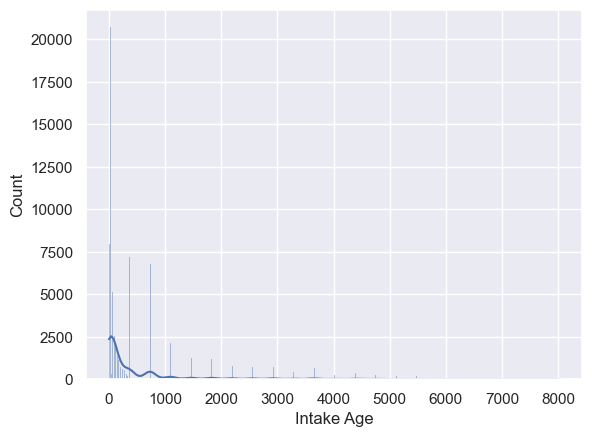

In [26]:
sns.histplot(cats['Intake Age'], kde=True)

# There are some outliers here that are probably not representative of the typical cat, such as the oldest cat admitted, who was reportedly 22 years old. 

In [27]:
# There are a number of ways to deal with the outliers here. 
# My first thought was to exclude cats further than 2 standard deviations from the mean. However, that would exclude every cat older than about 6 years old, which feels really limiting for the ultimate use of my model
# Instead choose to get rid of the most senior 1% of cats, which makes our new oldest intake about 12 years old. 
cats = cats[cats['Intake Age'] < (cats['Intake Age'].quantile(0.99))]
cats.describe()

Date of Birth    Intake Age  \
count                          65970  65970.000000   
mean   2017-06-30 05:50:00.818553856    429.660967   
min              2001-03-26 00:00:00      0.000000   
25%              2015-02-13 00:00:00     28.000000   
50%              2017-05-28 00:00:00     60.000000   
75%              2020-06-09 00:00:00    365.000000   
max              2024-06-25 00:00:00   4380.000000   
std                              NaN    787.749667   

                     Intake DateTime               Outcome DateTime  \
count                          65970                          65970   
mean   2018-09-23 11:51:57.313324288  2018-11-01 11:41:08.593906176   
min              2013-10-01 08:33:00            2013-10-01 10:39:00   
25%              2016-01-20 08:17:45            2016-03-17 15:49:00   
50%              2018-06-28 16:13:00            2018-08-13 20:23:30   
75%              2021-06-11 13:00:30            2021-07-19 17:29:15   
max              2024-06-28 16:29:00            2024-07-01 07:49:00   
std                              NaN                            NaN   

        Outcome Age  Duration of Stay  
count  65970.000000      65970.000000  
mean     460.973442         38.595589  
min        0.000000          0.000000  
25%       60.000000          2.000000  
50%       90.000000          8.000000  
75%      365.000000         35.000000  
max     5840.000000       3522.000000  
std      803.427684        143.224046

<Axes: xlabel='Intake Age', ylabel='Count'>

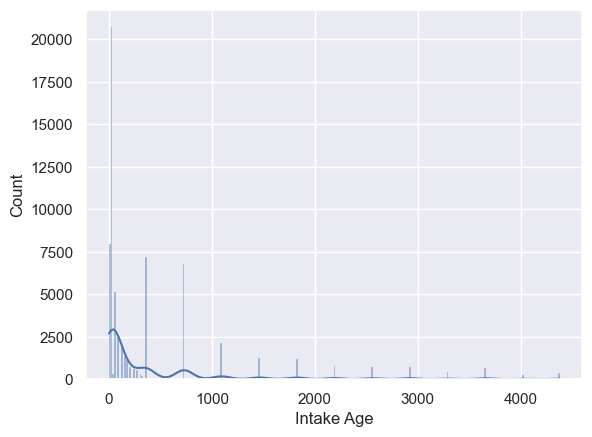

In [28]:
sns.histplot(cats['Intake Age'], kde=True)
# This data still has significant spread, so I may have to return to this decision if my OLS prediction is not good enough. 
# But I don't really want to make a model that is only applicable for non-senior cats. 

<Axes: xlabel='Duration of Stay', ylabel='Count'>

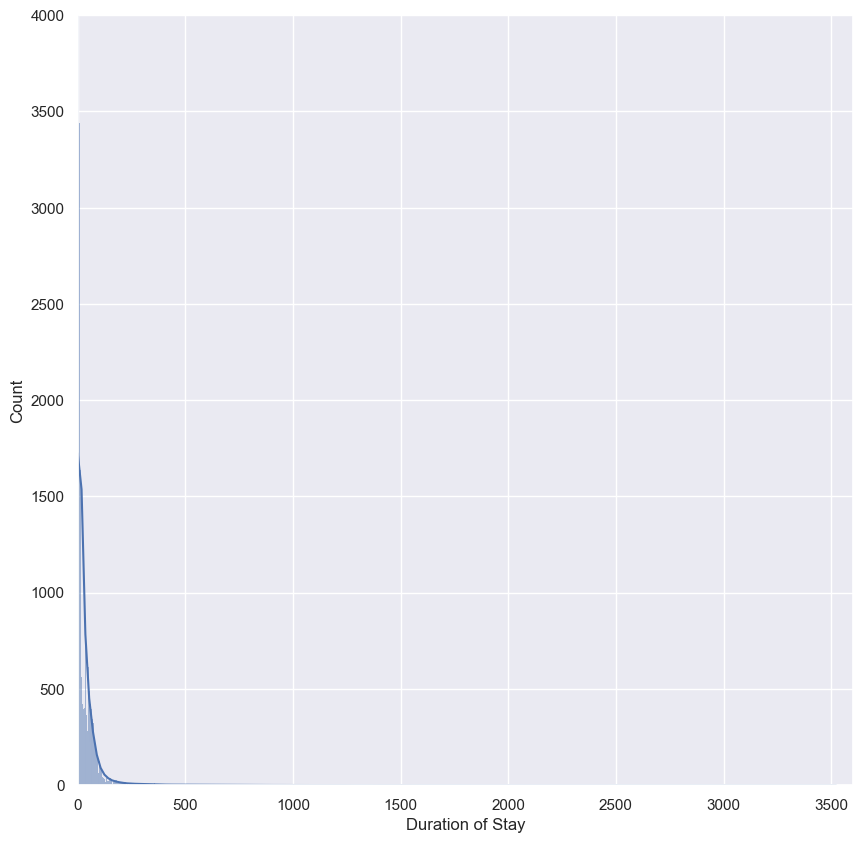

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plt.xlim(0,3600)
plt.ylim(0,4000)
sns.histplot(cats['Duration of Stay'], kde = True)

# The Duration of Stay data also has significant outliers
# Most cats are out of the shelter within a month, but some cats have stayed for nearly 10 years!
# Here it feels less egregious to discard samples more than 2 standard deviations from the mean, because this will remove cats in the shelter for more than 1 year, which still seems pretty generous.
# It might be interesting to investigate these "long haul" cats (who are in the shelter for longer than a year) to see what makes them harder to adopt out.

In [30]:
outliers = cats['Duration of Stay'].mean() + (2 * cats['Duration of Stay'].std())
outliers
cats = cats[cats['Duration of Stay'] < outliers]

In [31]:
cats.describe()

Date of Birth    Intake Age  \
count                          64889  64889.000000   
mean   2017-07-16 19:25:59.913082624    422.848079   
min              2001-03-26 00:00:00      0.000000   
25%              2015-03-04 00:00:00     28.000000   
50%              2017-06-11 00:00:00     60.000000   
75%              2020-06-23 00:00:00    365.000000   
max              2024-06-25 00:00:00   4380.000000   
std                              NaN    778.147594   

                     Intake DateTime               Outcome DateTime  \
count                          64889                          64889   
mean   2018-10-02 20:22:35.579836416  2018-10-27 03:55:15.831959040   
min              2013-10-01 08:33:00            2013-10-01 10:39:00   
25%              2016-02-02 14:50:00            2016-02-26 12:21:00   
50%              2018-07-09 17:01:00            2018-08-06 18:59:00   
75%              2021-06-21 17:07:00            2021-07-18 16:57:00   
max              2024-06-28 16:29:00            2024-07-01 07:49:00   
std                              NaN                            NaN   

        Outcome Age  Duration of Stay  
count  64889.000000      64889.000000  
mean     441.487432         23.918954  
min        0.000000          0.000000  
25%       60.000000          2.000000  
50%       90.000000          7.000000  
75%      365.000000         33.000000  
max     4745.000000        325.000000  
std      778.331939         38.440603

<Axes: xlabel='Duration of Stay', ylabel='Count'>

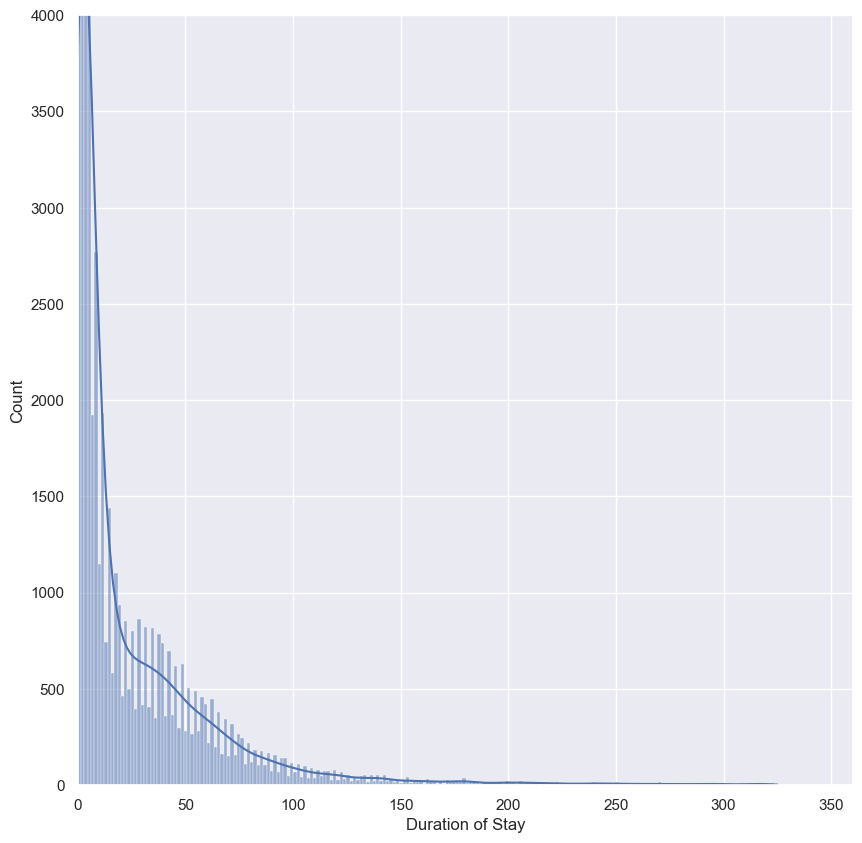

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plt.xlim(0,360)
plt.ylim(0,4000)
sns.histplot(cats['Duration of Stay'], kde = True)

# That looks much closer to normal

<Axes: xlabel='Outcome Age', ylabel='Count'>

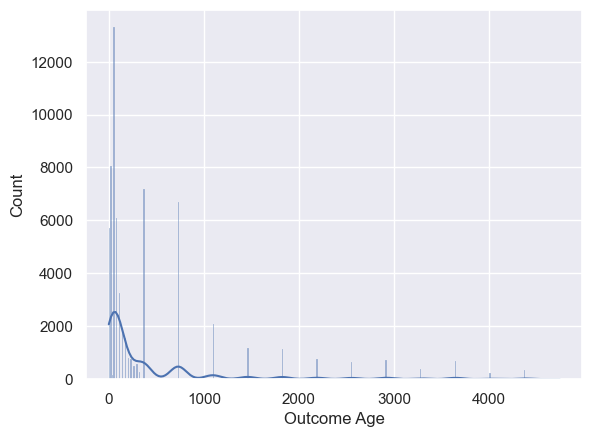

In [33]:
sns.histplot(cats['Outcome Age'], kde = True)
# The Outcome Age has similar problems as the Intake Age - it's very spread out, but limiting this data further might compromise the practical use of the model. 
# Since I have already managed outliers at the Duration of Stay and Intake Age variables (and because outcome age is related to both of those variables), I will leave it untouched for now. 

Text(0.5, 1.0, 'Duration of Stay & Outcome Age')

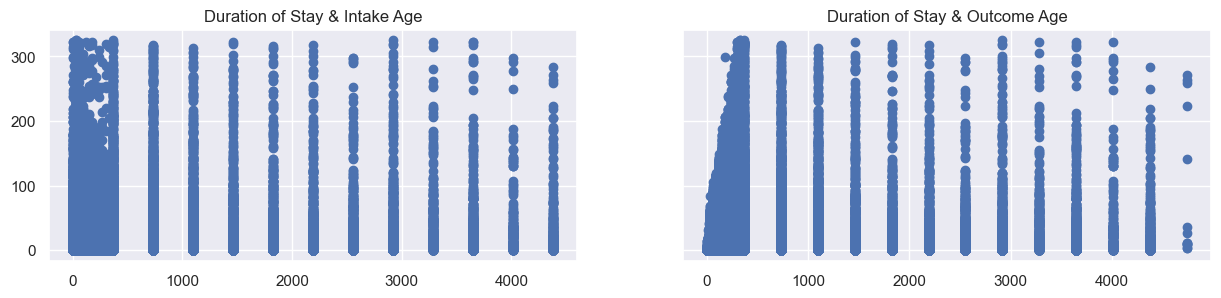

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(15,3)) #sharey -> share 'Duration of Stay' as y
ax1.scatter(cats['Intake Age'], cats['Duration of Stay'])
ax1.set_title('Duration of Stay & Intake Age')
ax2.scatter(cats['Outcome Age'], cats['Duration of Stay'])
ax2.set_title('Duration of Stay & Outcome Age')

# Doesn't look there's a strong correlation between Duration of stay and either of the age variables.  

Text(0.5, 1.0, 'Duration of Stay & Outcome Age')

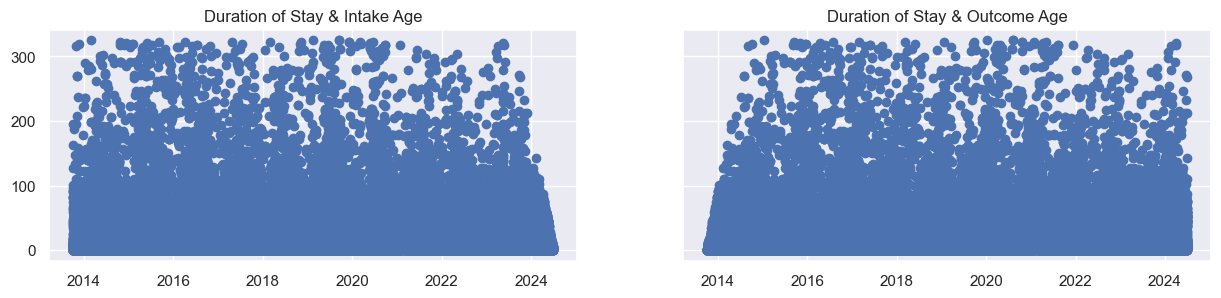

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(15,3)) #sharey -> share 'Duration of Stay' as y
ax1.scatter(cats['Intake DateTime'], cats['Duration of Stay'])
ax1.set_title('Duration of Stay & Intake Age')
ax2.scatter(cats['Outcome DateTime'], cats['Duration of Stay'])
ax2.set_title('Duration of Stay & Outcome Age')

# And it doesn't really look like the shelter has been getting significantly better or worse at placing cats quickly.

#### Initial Examination - Profiling Report

In [36]:
# Exploring data with ydata_profiling
cats_profile = ProfileReport(cats, title="Profiling Report")
cats_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Correlate Examination

In [37]:
# Outcome Type correlates most strongly with Outcome Subtype (0.84, but this is likely multicollinearity rather than a real independent correlation bc some outcome subtypes are used only with certain outcome types).
# If I was interested in the granularity that the subtypes provide, I might combine the subtype & outcome type information. If I'm not interested in that granularity, I may need to drop Subtype to reduce multicollinearity.

# The other features that correlate with Outcome Type seem to be Intake & Outcome Reproductive Status (0.3 and 0.5 respectively). This might be because the shelter does not spay/neuter an animal that is going back to its 
# original owner, but would spay/neuter a pet adopted to a new home. I can see if this is the case by making contingency tables examining these features more closely. 

# The next most strongly correlated features are Sex (0.21) and Intake Condition (0.2), so they might also be worth further investigation. 

##### Custom Stacked Bar Chart

In [38]:
# I want to use a stacked bar chart to visualize the relationships between some of these categorical variables because it's more intuitive than a contingency table.

def stacked_bar_chart (x, y, data):
    %matplotlib inline
    palette = sns.color_palette("Spectral")

    # make a contingency table of provided data for provided categorical variables
    crosstab = pd.crosstab(data[x], data[y], normalize = False)

    # make a stacked bar chart
    fig, ax = plt.subplots()
    crosstab.plot(kind = 'bar', stacked = True, rot = 0, ax = ax, color=palette)
    ax.set_ylabel('Number of Animals')
    ax.set_title('{} by {}'.format(y, x), loc='center')
    ax.legend(title="{}".format(y))

    # adding percentages of total bar as overlying bar labels
    row_sums = crosstab.sum(axis = 1)
    percentages = (crosstab.div(row_sums, axis = 0)) *100

    # Initialize bottom array for stacking
    bottom = np.zeros(len(crosstab.index))
    flip = False
    color_index = 0 

    # Plot each category as a separate set of bars, stacking them
    for column_name, column_data in crosstab.items():
        p = ax.bar(crosstab.index, column_data, width = 0.6, label=column_name, bottom=bottom, color=palette[color_index])
        bottom += column_data
        color_index = (color_index + 1) % len(palette)

        # Annotate each bar with its percentage
        for i, patch in enumerate(p):
            percentage = percentages.loc[crosstab.index[i], column_name]
            percentage_str = f'{percentage:.1f}%'
            
            # Determine if the text should be placed inside or outside the bar & assign color (assuming white plot background)
            text_position = 'inside' if patch.get_height() > 1000 else 'outside'
            text_color = 'white' if palette[0] == '#999999' else 'black'

            if text_position == 'inside':
                ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                            textcoords="offset points", xytext=(0, 0), ha='center', va='center', fontsize=8)
            else:
                if flip == False:
                    if percentage < 2:
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (7, 2), ha='right', va='top', fontsize=9, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'}) 
                    else:    
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (7, 1), ha='right', va='bottom', fontsize=8, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'})  
                    flip = True 
                else:         
                    if percentage < 2:
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (-7, 2), ha='left', va='top', fontsize=9, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'}) 
                    else:    
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (-7, 1), ha='left', va='bottom', fontsize=8, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'})  
                    flip = False
    # formatting
    plt.show()


##### Stacked Bar Chart Visualizations (Sex, Intake Conditions)

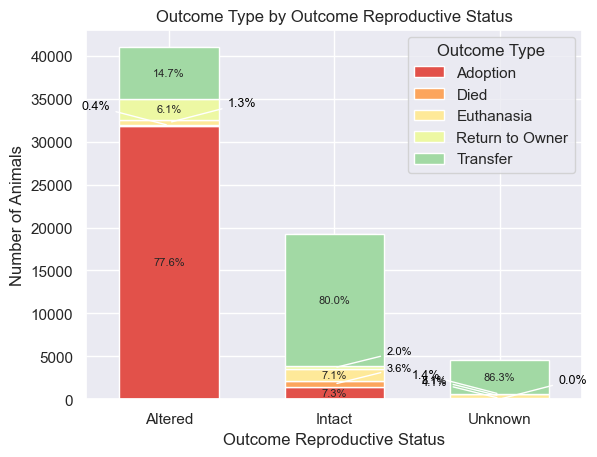

In [39]:
stacked_bar_chart('Outcome Reproductive Status', 'Outcome Type', cats)

# Cats that are altered at the time of outcome are much more likely to have an adopted outcome type than intact or unknown cats. This is likely because most shelters have a policy against adopting out intact animals. 
# So being spayed/neutered is unlikely to contribute to the adoption; correlation does not imply causation. 

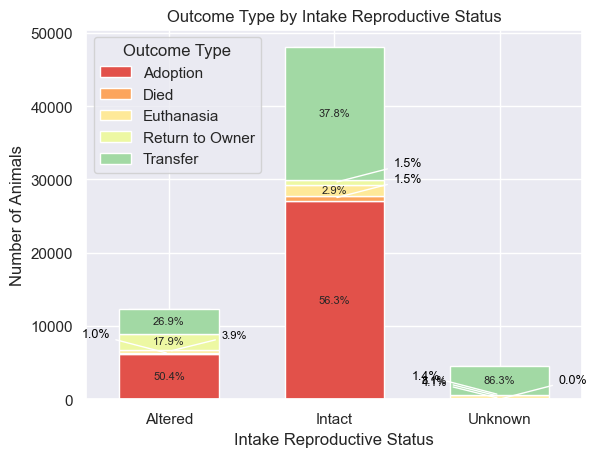

In [40]:
stacked_bar_chart('Intake Reproductive Status', 'Outcome Type', cats)

# Cats that are already spayed/neutered show a similar rate of adoption, which suggests reproductive status is not as important as the previous chart would suggest. This fits with 
# the consideration that the shelter policy is causing the higher "adoption rate" of altered animals. 

# Additionally, we can see that animals who are already spayed/neutered on intake have a higher change of being returned to an owner. Animals are often microchipped at the time
# of their spay/neuter surgery, so microchips might be a confounding factor that contributes to the higher "return to owner" rate for these animals.

# For both intake and outcome reproductive status, the animals with "unknown" status are much more likely to be transferring to another facility than otherwise. 
# This might be explained by an incomplete physical exam or choice not to spay/neuter for animals slated for transfer. 

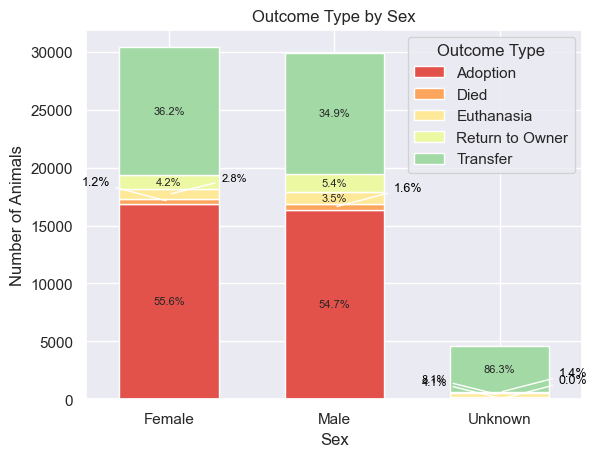

In [41]:
stacked_bar_chart('Sex', 'Outcome Type', cats)

# The heatmap in my profile suggested a weak correlation between outcome type & sex, but I suspect it was just noticing
# the "unknown" animals being much more likely to be transferred elsewhere. The outcome types among the male & female animals
# are very similar. 

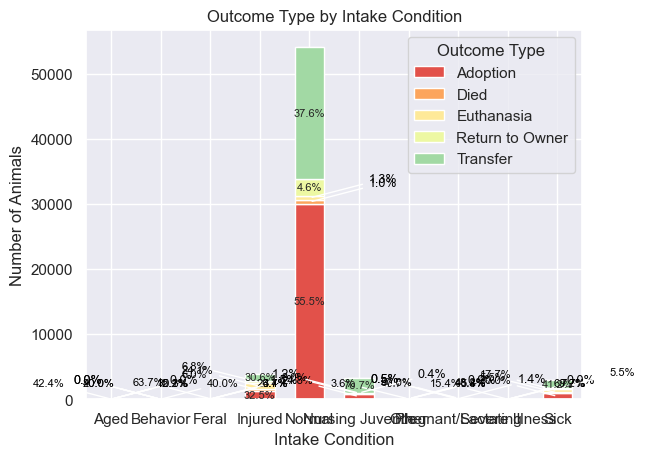

In [42]:
stacked_bar_chart('Intake Condition', 'Outcome Type', cats)

# This chart shows the problem of one group (the Intake Condition: Normal) being so overrepresented that the 
# other groups become impossible to interpret. If I wanted to correct this problem, I could balance my data
# and make this chart again. But since I'm just exploring and not balancing yet, I will just examine the other
# groups without the unbalanced, overrepresented one. I can still directly compare the percentages (ie. what
# percentage of Normal intakes ended up adopted vs the percentage adopted in another group)

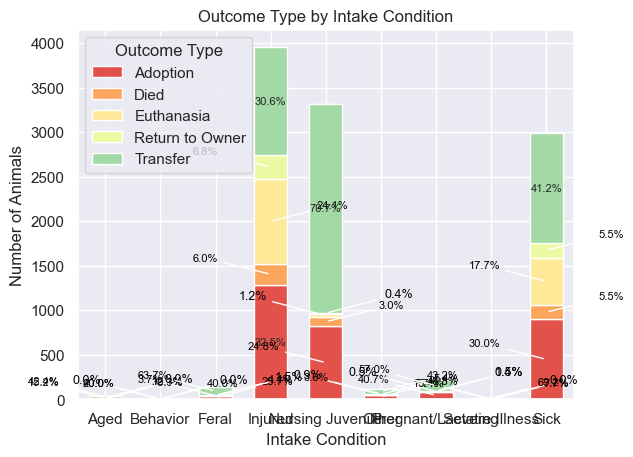

In [43]:
cats_without_normal_intakes = cats.loc[cats['Intake Condition'] != 'Normal']
stacked_bar_chart('Intake Condition', 'Outcome Type', cats_without_normal_intakes)

# Better - but the scale of animals in some of these smaller categories is still unwieldly. 
# Let's just look at a contingency table...

In [44]:
crosstab = pd.crosstab(cats['Intake Condition'], cats['Outcome Type'], normalize = False) # I don't love the default normalization, so I convert to percentages myself.
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# Even though my initial profile found only mild-moderate correlation between Intake condition & Outcome type, it makes logical sense that it would be important, and 
# the data fits with that when we take a closer looks. I suspect if I balanced the data before running the profile, this correlation would probably be much stronger
# It definitely looks like any not-normal animal has a lower adoption rate. The injured, sick, and aged animals have much higher euthanasia rates, and 
# almost all the not-normal intake conditions have higher transfer rates (suggesting they might be transferred to shelters/rescues more suitable for their specific condition). 

# Additionally, Aged, Behavior, and Severe Illness categories are much more likely to be returned to their owners. 
# I can think of a number of reasons this might be the case:
#   - the shelter knows the likelihood of adopting that animal out is lower, so they try harder to find a solution with the current owner
#   - the owner decides to palliate or euthanize the pet at home rather than putting it through the stress of the shelter system
#   - the owner decides to get medical/behavioral care for their pet elsewhere rather than relinquishing them
#   - alternately, it could be that the "return to owner" rates are lower for the other intake conditions because they are "diluted" by stray pets who never had an owner

# I cannot explain a 4.5% "return to owner" rate for supposedly feral animals. Unless "owner" in this case implies "the person who brought the feral, unowned animal to the shelter"
# Maybe these could be barn cats or colony cats that the "owner" is returning to wherever they found them. 
# It could also be that the "feral" intake condition is being applied to animals who aren't actually feral. 

Outcome Type         Adoption      Died  Euthanasia  Return to Owner  \
Intake Condition                                                       
Aged                30.303030  0.000000   15.151515        12.121212   
Behavior            40.000000  0.000000    0.000000        20.000000   
Feral               26.666667  1.481481    3.703704         4.444444   
Injured             32.498735  6.019221   24.051593         6.828528   
Normal              55.536051  0.959015    1.339665         4.602905   
Nursing Juvenile    24.766496  2.952697    1.235312         0.361555   
Other               46.846847  0.900901    5.405405         3.603604   
Pregnant/Lactating  40.654206  0.467290    0.467290         1.401869   
Severe Illness       0.000000  7.692308    7.692308        15.384615   
Sick                29.996652  5.523937   17.743555         5.523937   

Outcome Type         Transfer  
Intake Condition               
Aged                42.424242  
Behavior            40.000000  
Feral               63.703704  
Injured             30.601922  
Normal              37.562364  
Nursing Juvenile    70.683941  
Other               43.243243  
Pregnant/Lactating  57.009346  
Severe Illness      69.230769  
Sick                41.211918

##### Violin Plot Visualizations (Age & Duration of Stay)

Text(0.5, 1.0, 'Intake Age by Outcome Type')

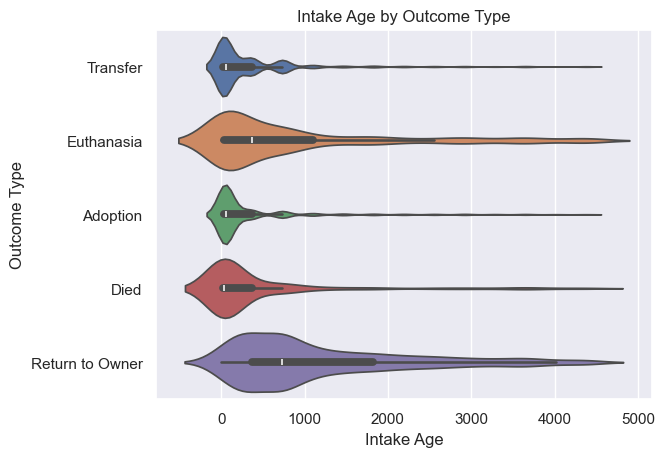

In [45]:
ax = sns.violinplot(x='Intake Age', y='Outcome Type', hue='Outcome Type', data=cats)
ax.set_title('Intake Age by Outcome Type', loc='center')

# Even though my profile showed a very mild correlation between intake age & outcome type, I wanted to look more closely because
# logic suggests an older animal might have a harder time getting adopted. 
# Because so many of the animals taken in by the shelter skew younger in age, we see most of the data concentrated there (almost all the pets are <5.5 years old - 2000 days)
# That said, you can see the average age of euthanized pets and pets returned to owner are older than the adoption age and transfer ages.
# The IQR of pets who end up euthanized or returned to their owners is also much wider than for Transfer/Adoption/Death outcomes 
# 
# Additionally, the animals that have died skew younger than those adopted, which suggests the neonatal death rate is higher than for other groups
# That's also supported by the contingency table above, which shows "nursing juvenile" cats have a 3% death rate (twice as high as "aged" animals and 3x higher than "normal" intake).

Text(0.5, 1.0, 'Duration of Stay by Outcome Type')

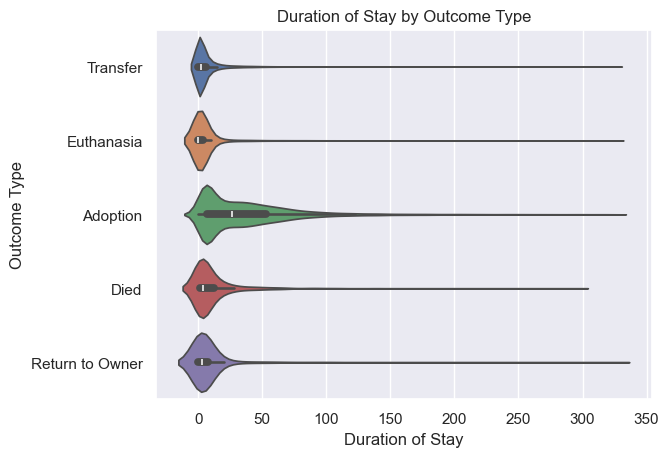

In [46]:
ax = sns.violinplot(x='Duration of Stay', y='Outcome Type', hue='Outcome Type', data=cats)
ax.set_title('Duration of Stay by Outcome Type', loc='center')

# Even though there was minimal correlation identified in the profile for Duration of Stay, I wanted to look
# more closely that this feature because it's another one that I could explain logically. With this violin plot, 
# I can see that the pets destined for transfer seem to do so very quickly, but otherwise, there is no clear change
# in duration of stay for each outcome type. And there are Duration of Stay outliers that conclude with each of the 
# outcome types. There could still be a mild correlation that is obscured because the data is not balanced for duration 
# of stay, but I don't feel like I have to use this as a feature. 

##### Violin Plot + Time Visualizations (Changes in Outcome over Time)

Text(0.5, 1.0, 'Distribution of Outcome Type over Intake Time')

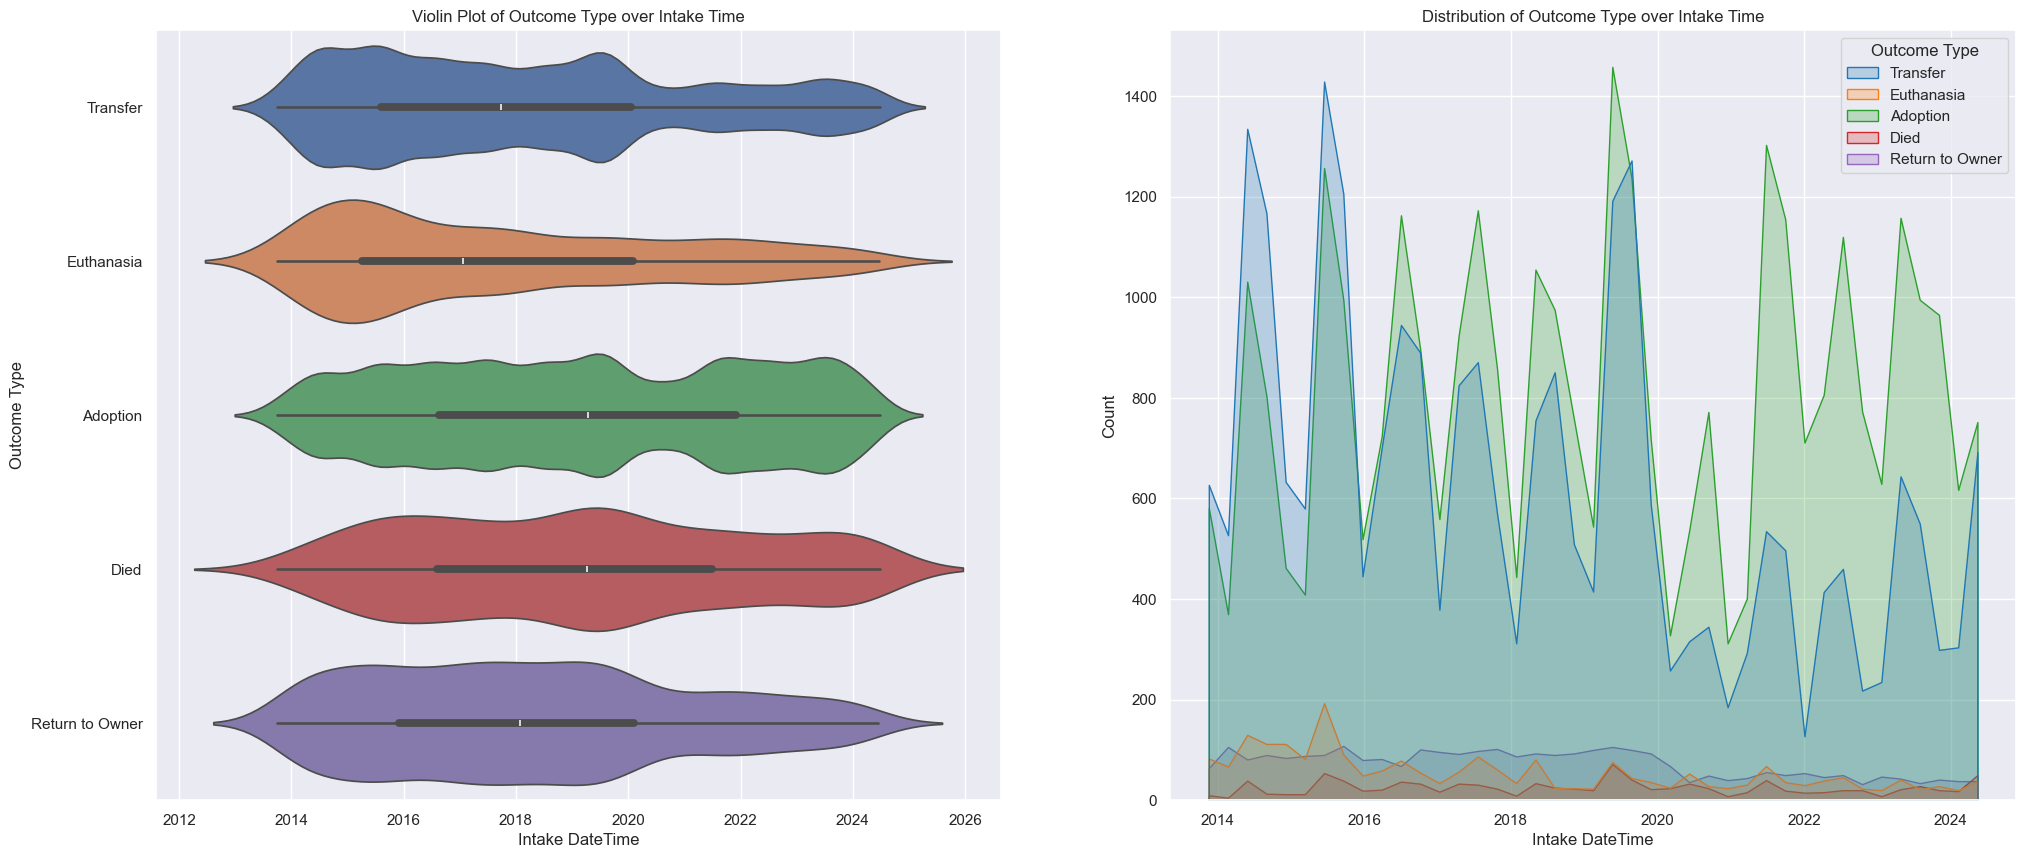

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))
sns.violinplot(x='Intake DateTime', y='Outcome Type', hue='Outcome Type', data=cats, ax=axs[0], label = 'Violin Plot')
axs[0].set_title('Violin Plot of Outcome Type over Intake Time')
sns.histplot(data=cats, x= 'Intake DateTime', hue='Outcome Type', palette = 'tab10', kde = False, stat = 'count', element = 'poly', ax = axs[1], label = 'Distribution over Time')
axs[1].set_title('Distribution of Outcome Type over Intake Time')

# There's a lot of information to get out of these graphs, which show the trends in outcome types over time (intake time in this case)
# First, you can see on the distribution plot that there is definite periodicity to the adoption pattern; we'll see if this shows up on the outcome datetime plots as well. 
#   - This suggests a definite, predictable "busy period" for intakes depending on the season (possibly down to the month). This may or may not impact a specific cat's chance of getting adopted (since this shelter does not have a "time limit" before a pet is euthanized)
# Second, the shelter is performing fewer euthanasias over time. 
#   - On the left, we see the density increased in the 2014-2016 time period, with a gradual decline since. This fits with the fact that this shelter moved to a "no kill" paradigm starting in 2011.
#   - On the right, there is a spike in euthanasias in 2015. There was a panleukopenia outbreak in the shelter around this time that can explain this irregularity.
# Third, the shelter relies less on Transfers now than previous. This fits with some news I found regarding a change in contract between the shelter and a particularly large rescue that significantly decreased the number of transfers the rescue had to accept per year.
# Fourth, there has been a general decrease in "Return to Owner" outcomes over the last several years. 
# Fifth, The death rate is relatively consistent (and mildly decreaseing over time) with the exception of a period in 2019 that matches up with another outbreak of panleukopenia. 
# Lastly, you can clearly see the COVID pandemic's effect on the number of adoptions in the 2020-21 years. The adoption rate has since recovered, though the transfer rate and return to owner rates have not. 
#   - you can also see a spike in adoptions and transfers at the start of 2020, which fits with the "adoption boom" of "pandemic pets"

# Ultimately, even though this information is interesting, I don't think it will significantly impact the questions I'm focusing on right now. Perhaps a new pet is less likely to be transferred, euthanized, or returned to their previous owner, but ther rates seems relatively steady over the last several years. I would be curious to see if the model I develop would be different if I train it on data from pre-2020 vs post-2022 data. 

Text(0.5, 1.0, 'Distribution of Outcome Type over Outcome Time')

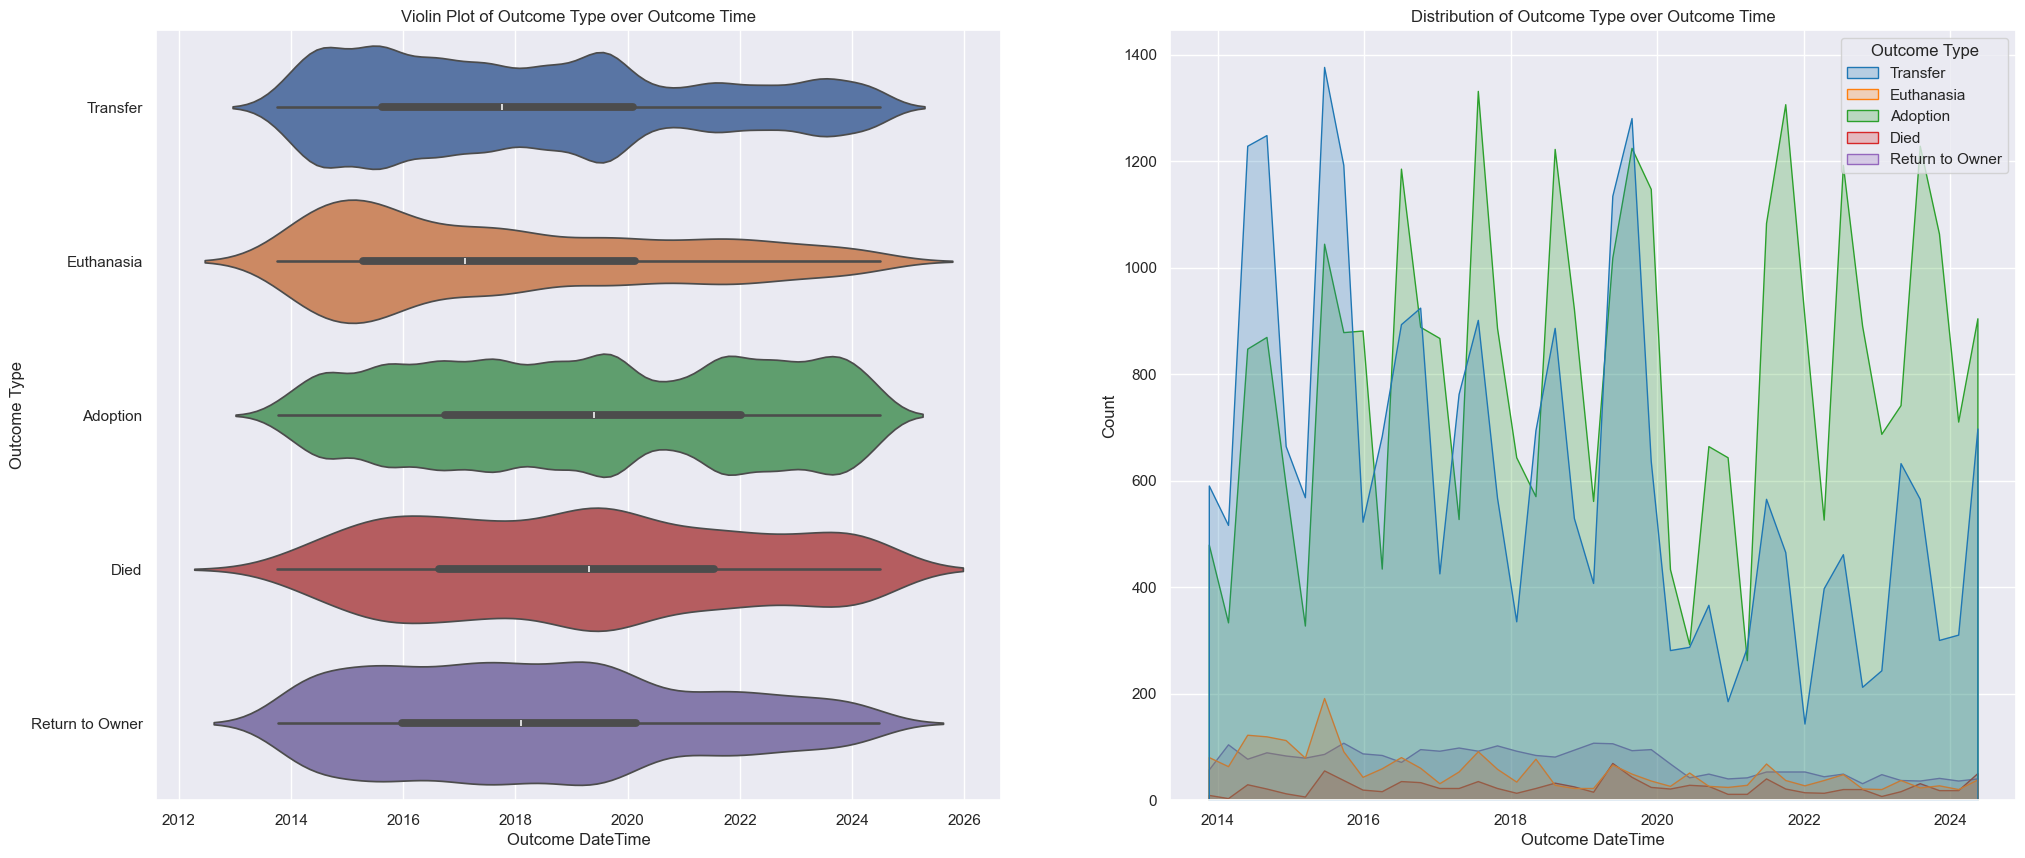

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))
sns.violinplot(x='Outcome DateTime', y='Outcome Type', hue='Outcome Type', data=cats, ax=axs[0], label = 'Violin Plot')
axs[0].set_title('Violin Plot of Outcome Type over Outcome Time')
sns.histplot(data=cats, x= 'Outcome DateTime', hue='Outcome Type', palette = 'tab10', kde = False, stat = 'count', element = 'poly', ax = axs[1], label = 'Distribution over Time')
axs[1].set_title('Distribution of Outcome Type over Outcome Time')

# This data mirrors much of what I found from the Intake DateTime examination, including the spikes in euthanasia and deaths matching up with panleukopenia outbreaks. 
# But again, I don't think there is much that will change my predictions for a given cat's outcome. 

##### Contingency Tables w/ stacked bar charts (Color & Pattern Features)

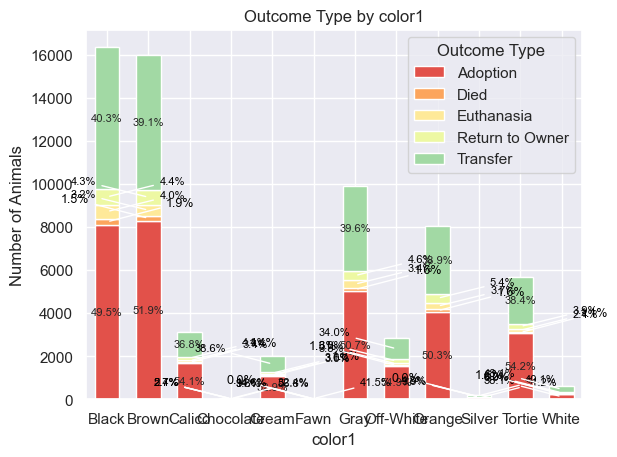

In [49]:
temp = cats.loc[cats['color1'] != 'Empty Color']
#temp['color1'].unique()
stacked_bar_chart('color1', 'Outcome Type', temp)

# This is messy, but I can see the most common color types: black, brown, gray, orange, and tortie
# And I can directly compare some of the adoption percentages. Torties do well (54% adoption), and black-based cats do less well (49.5% adoption). 

In [50]:
# A contingency table of the above information.
crosstab = pd.crosstab(temp['color1'], temp['Outcome Type'], normalize = False)
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# A contingency table shows there is probably a real correlation between base color and outcome type. 
# White and fawn cats seem to underperform (38% and 34% adoption) vs the highest adoption percentage (chocolate-based cats at 56.7%)
# Keeping in mind the base adoption % for all cats is 51%
# There is also an increase in euthanasias among fawn & white cats that I can't explain but is probably tied to the lower adoption rates. 
# Additionally both white and fawn cats have a higher likelihood of being returned to their owners. 

Outcome Type   Adoption      Died  Euthanasia  Return to Owner   Transfer
color1                                                                   
Black         49.453235  1.887715    3.952593         4.392449  40.314008
Brown         51.887736  1.456432    3.237905         4.306788  39.111139
Calico        54.084237  1.403957    3.350351         4.371410  36.790045
Chocolate     56.756757  2.702703    2.702703         5.405405  32.432432
Cream         52.926709  1.819970    3.000492         3.639941  38.612887
Fawn          34.146341  0.000000    9.756098        14.634146  41.463415
Gray          50.747777  1.637025    3.435732         4.587712  39.591754
Off-White     54.927587  1.306959    3.779583         5.969622  34.016249
Orange        50.322901  1.577248    3.738202         5.427223  38.934426
Silver        51.207729  0.000000    3.864734         4.830918  40.096618
Tortie        54.168870  1.145778    2.397321         3.930901  38.357130
White         38.149351  1.623377    6.006494         6.168831  48.051948

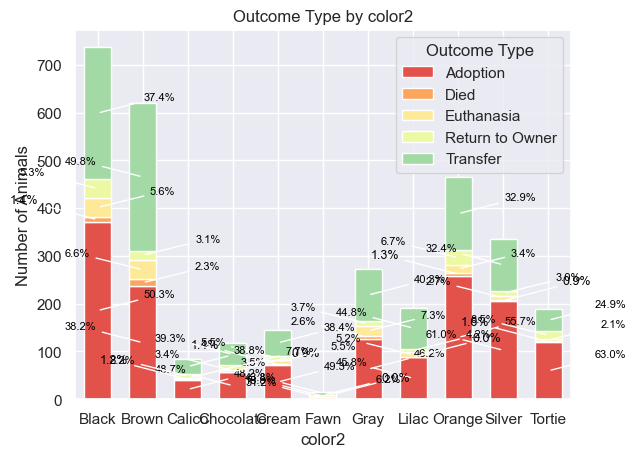

In [51]:
temp = cats.loc[cats['color2'] != 'Empty Color']
stacked_bar_chart('color2', 'Outcome Type', temp)

In [52]:
# A contingency table of the above information.
crosstab = pd.crosstab(temp['color2'], temp['Outcome Type'], normalize = False)
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# Cats that have Tortie , Silver, or Orange as their secondary color seem to outperform the average cat. 


Outcome Type   Adoption      Died  Euthanasia  Return to Owner   Transfer
color2                                                                   
Black         50.339213  1.356852    5.563094         5.291723  37.449118
Brown         38.225806  2.258065    6.612903         3.064516  49.838710
Calico        48.235294  1.176471    3.529412         8.235294  38.823529
Chocolate     48.717949  0.854701    3.418803         7.692308  39.316239
Cream         49.315068  1.369863    5.479452         5.479452  38.356164
Fawn          31.250000  0.000000   18.750000         6.250000  43.750000
Gray          46.153846  2.564103    7.326007         3.663004  40.293040
Lilac         45.833333  0.000000    5.208333         4.166667  44.791667
Orange        55.698925  1.290323    3.440860         6.666667  32.903226
Silver        61.011905  0.892857    2.678571         2.976190  32.440476
Tortie        62.962963  1.587302    2.116402         8.465608  24.867725

###### Fawn Euthanasia Tangent

In [53]:
# Tangent! I'm really curious why cats with Fawn as their secondary color have a higher rate of euthanasia. I can't imagine what's going on there. 

cats.loc[cats['color2'] == 'Fawn']

# Just eyeballing the data, it seems like cats with Fawn as their secondary color have a lot more sick and injured cats than I would expect from a random sample. 

Animal ID Date of Birth     Sex               Breed             Color  \
37920    A707324    2015-06-11  Female  Domestic Shorthair    Blue Tabby/Tan   
59799    A731479    2015-07-23    Male  Domestic Shorthair    Lynx Point/Tan   
81168    A754886    2016-07-26  Female  Domestic Shorthair          Gray/Tan   
87415    A761914    2005-11-11  Female             Siamese         Tan/Brown   
95334    A770866    2010-04-26    Male  Domestic Shorthair   Tan/Cream Tabby   
96275    A771981    2018-04-13  Female  Domestic Shorthair         Tan/Brown   
97469    A773333    2010-05-30  Female             Siamese         Tan/Brown   
98834    A774809    2006-06-21  Female             Siamese         Tan/Brown   
105489   A782089    2016-10-10  Female  Domestic Shorthair         Tan/Black   
144818   A832966    2011-04-21  Female             Siamese         Cream/Tan   
157315   A852010    2021-02-23    Male             Siamese    Lynx Point/Tan   
158672   A854609    2020-04-06    Male  Domestic Shorthair   Brown Tabby/Tan   
170385   A876108    2022-11-24    Male   Domestic Longhair  Orange Tabby/Tan   
175596   A885894    2023-07-05    Male  Domestic Shorthair   Brown Tabby/Tan   
175627   A885938    2023-05-13  Female  Domestic Shorthair    Gray Tabby/Tan   
175665   A886022    2018-07-29  Female             Siamese         Fawn/Gray   

            Intake Type Intake Condition  Intake Age  \
37920             Stray           Normal          28   
59799             Stray          Injured         365   
81168             Stray           Normal         365   
87415   Owner Surrender           Normal        4380   
95334             Stray          Injured        2920   
96275             Stray             Sick          28   
97469   Owner Surrender           Normal        2920   
98834             Stray             Sick        4380   
105489            Stray          Injured         730   
144818            Stray          Injured        3650   
157315            Stray          Injured         365   
158672            Stray          Injured         730   
170385            Stray           Normal          90   
175596            Stray           Normal          21   
175627            Stray           Normal          60   
175665            Stray           Normal        1825   

       Intake Reproductive Status     Intake DateTime  ... Duration of Stay  \
37920                      Intact 2015-07-11 12:48:00  ...               38   
59799                      Intact 2016-07-23 02:47:00  ...               44   
81168                      Intact 2017-07-26 10:07:00  ...                4   
87415                      Intact 2017-11-11 13:55:00  ...                3   
95334                      Intact 2018-04-26 14:02:00  ...                0   
96275                      Intact 2018-05-13 11:03:00  ...                0   
97469                      Intact 2018-05-30 15:17:00  ...                2   
98834                      Intact 2018-06-20 15:51:00  ...                1   
105489                     Intact 2018-10-10 14:27:00  ...                0   
144818                    Altered 2021-04-21 17:24:00  ...                7   
157315                     Intact 2022-02-23 09:01:00  ...                9   
158672                     Intact 2022-04-06 15:43:00  ...               17   
170385                     Intact 2023-03-09 15:08:00  ...                4   
175596                     Intact 2023-07-27 11:14:00  ...                0   
175627                     Intact 2023-07-27 18:29:00  ...               24   
175665                    Altered 2023-07-29 10:28:00  ...                7   

                      Breed2 Purebred?  Coat Length     color1  color2  \
37920           Not Provided     False        short       Gray    Fawn   
59799           Not Provided     False        short  Off-White    Fawn   
81168           Not Provided     False        short       Gray    Fawn   
87415                Unknown     False      Unknown  

###### Back to Continency Tables & Stacked Bar Charts

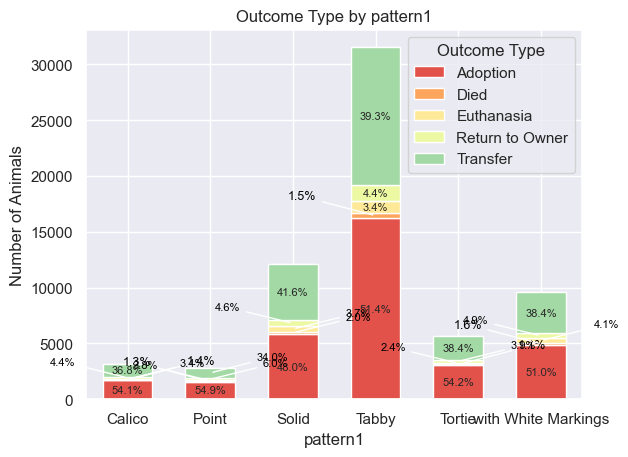

In [54]:
stacked_bar_chart('pattern1', 'Outcome Type', cats)

In [55]:
# A contingency table of the above information.
crosstab = pd.crosstab(cats['pattern1'], cats['Outcome Type'], normalize = False)
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# Solid color cats have a disadvantage to adoption; Torties/Calicos/Point patterns perform better than average

Outcome Type          Adoption      Died  Euthanasia  Return to Owner  \
pattern1                                                                
Calico               54.084237  1.403957    3.350351         4.371410   
Point                54.927587  1.306959    3.779583         5.969622   
Solid                48.043263  2.022787    3.707067         4.648283   
Tabby                51.385279  1.521588    3.404552         4.422114   
Tortie               54.168870  1.145778    2.397321         3.930901   
with White Markings  51.005942  1.605337    4.107161         4.909830   

Outcome Type          Transfer  
pattern1                        
Calico               36.790045  
Point                34.016249  
Solid                41.578600  
Tabby                39.266468  
Tortie               38.357130  
with White Markings  38.371729

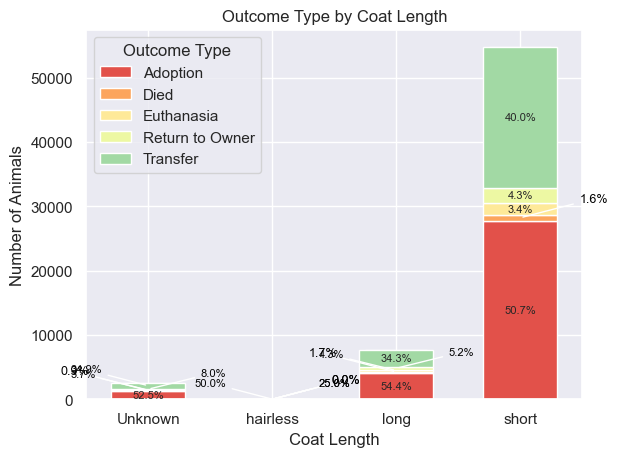

In [56]:
stacked_bar_chart('Coat Length', 'Outcome Type', cats)

# Long haired cats seem to have a slight advantage over short haired cats.
# And hairless cats are more likely to be returned to their owners (though there are only a few of them in the dataset) 

In [57]:
# A contingency table of the above information
crosstab = pd.crosstab(cats['Coat Length'], cats['Outcome Type'], normalize = False)
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

Outcome Type   Adoption      Died  Euthanasia  Return to Owner   Transfer
Coat Length                                                              
Unknown       52.482270  0.945626    3.664303         7.959023  34.948779
hairless      25.000000  0.000000    0.000000        50.000000  25.000000
long          54.430878  1.732966    4.332414         5.198897  34.304844
short         50.732688  1.587795    3.365613         4.308423  40.005481

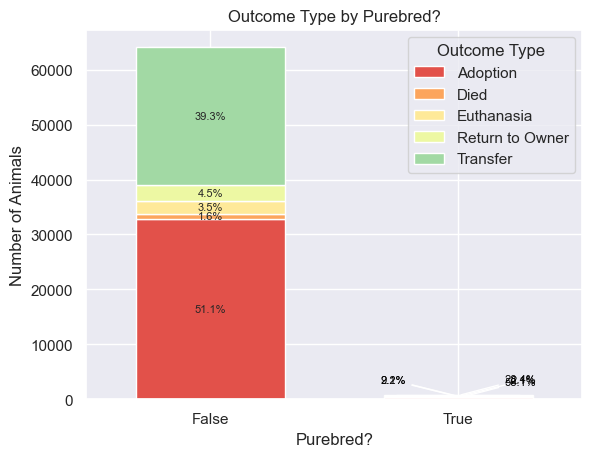

In [58]:
stacked_bar_chart('Purebred?', 'Outcome Type', cats)

In [59]:
# A contingency table of the above information
crosstab = pd.crosstab(cats['Purebred?'], cats['Outcome Type'], normalize = False)
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# And cats described as purebred have a higher adoption rate than other cats. They are also more likely to be returned to their owners.

Outcome Type   Adoption      Died  Euthanasia  Return to Owner   Transfer
Purebred?                                                                
False         51.149040  1.572617    3.507184         4.500991  39.270169
True          58.080808  2.146465    2.146465         9.217172  28.409091

In [60]:
# A contingency table of breeds vs Outcome Type
crosstab = pd.crosstab(cats['Breed'], cats['Outcome Type'], normalize = False)
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# For most of these breeds, it's clear we don't have enough data to make good correlations 

Outcome Type               Adoption       Died  Euthanasia  Return to Owner  \
Breed                                                                         
Abyssinian                61.904762   0.000000    0.000000         9.523810   
American Curl Shorthair   70.000000   0.000000    0.000000         5.000000   
American Shorthair        41.240876   1.459854    2.189781         7.664234   
American Wirehair        100.000000   0.000000    0.000000         0.000000   
Angora                    46.153846   0.000000    0.000000        15.384615   
Balinese                  75.000000   5.000000    5.000000         0.000000   
Bengal                    61.290323   0.000000    0.000000        29.032258   
Birman                     0.000000   0.000000    0.000000         0.000000   
Bombay                    44.444444   0.000000    0.000000        44.444444   
British Shorthair         60.000000   0.000000    6.666667        20.000000   
Burmese                   66.666667   0.000000    0.000000         0.000000   
Chartreux                  0.000000   0.000000    0.000000         0.000000   
Colorpoint                 0.000000   0.000000    0.000000         0.000000   
Cornish Rex               25.000000  25.000000    0.000000        50.000000   
Cymric                    75.000000   0.000000    0.000000         0.000000   
Devon Rex                 54.545455   0.000000    0.000000        18.181818   
Domestic Longhair         54.572778   1.631602    5.238300         6.698154   
Domestic Medium Hair      54.386302   1.750673    3.963063         4.251635   
Domestic Shorthair        50.620347   1.583275    3.381356         4.266509   
Exotic Shorthair           0.000000   0.000000   25.000000         0.000000   
Havana Brown              50.000000   0.000000    0.000000         0.000000   
Himalayan                 45.312500   3.125000    6.250000        17.187500   
Japanese Bobtail          72.727273   0.000000    0.000000         0.000000   
Javanese                 100.000000   0.000000    0.000000         0.000000   
Maine Coon                60.130719   0.653595    2.614379        14.379085   
Manx                      52.000000   0.666667    1.333333         9.333333   
Munchkin Longhair          0.000000   0.000000    0.000000         0.000000   
Munchkin Shorthair       100.000000   0.000000    0.000000         0.000000   
Norwegian Forest Cat      75.000000   0.000000    0.000000         0.000000   
Ocicat                   100.000000   0.000000    0.000000         0.000000   
Oriental Sh               75.000000   0.000000    0.000000        25.000000   
Persian                   60.526316   0.000000    5.263158         7.894737   
Pixiebob Shorthair       100.000000   0.000000    0.000000         0.000000   
Ragdoll                   55.405405   1.351351    4.054054         8.108108   
Russian Blue              53.488372   1.550388    0.775194        15.503876   
Savannah                   0.000000   0.000000    0.000000       100.000000   
Scottish Fold            100.000000   0.000000    0.000000         0.000000   
Siamese                   53.806847   1.328564    3.934594         7.000511   
Snowshoe                  60.507246   0.724638    2.173913         3.985507   
Sphynx                    25.000000   0.000000    0.000000        50.000000   
Tonkinese                 50.000000   0.000000   16.666667        16.666667   
Turkish Angora            25.000000   0.000000   12.500000        12.500000   
Turkish Van              100.000000   0.000000    0.000000         0.000000   

Outcome Type               Transfer  
Breed                                
Abyssinian                28.571429  
American Curl Shorthair   25.000000  
American Shorthair        47.445255  
American Wirehair          0.000000  
Angora                    38.461538  
Balinese                  15.000000  
Bengal                     9.677419  
Birman                   100.000000  
Bombay                    11.111111  
British Shorthair         

In [61]:
# Since I'm not seeing clear relationships that I can relax to meet the requirements of linear regession, I'm
# going to instead train a machine learning algorithm. 

#### Preprocessing for Machine Learning

##### Convert Date Time Features

In [62]:
# Before passing my datetime features into an ML, I'd like to preprocess them to get the best information from them. 
# I have Date of Birth, Intake DateTime, Outcome DateTime, which are all expressed as Timestamps right now.
# I intend to keep the year intact as a numerical, convert the month into a cyclically encoded numerical, and add a boolean for "is weekend" to apply to the intake & outcome datetimes. I don't feel like I need the granularity of the day of the month for any of these. 

def timestamp_preprocessing(row):
    dob = row['Date of Birth']
    intake = row['Intake DateTime']
    outcome = row['Outcome DateTime']

    # convert Date of Birth to year & month
    dob_year = dob.year
    dob_month = dob.month

    # convert Intake Date Time to year & month
    # By converting the month to a sin function, I hope to keep month encoded as a cyclical numerical (instead of each month being a categorical), so the ML will not treat January & December as opposite ends of a spectrum
    # declare true/false for day of week is weekday
    intake_year = intake.year
    intake_month = np.sin(2 * np.pi * intake.month/12)
    if (intake.isoweekday() >= 6):
        intake_weekend = True
    else:
        intake_weekend = False

    # convert Outcome Date Time to year & month
    # by converting the month to a sin function, I hope to keep month encoded as a cyclical numerical (instead of each month being a categorical), so the ML will not treat January & December as opposite ends of a spectrum
    # declare true/false for day of week is weekday
    outcome_year = outcome.year
    outcome_month = np.sin(2 * np.pi * outcome.month/12)
    if (outcome.isoweekday() >= 6):
        outcome_weekend = True
    else:
        outcome_weekend = False
    
    return dob_year, dob_month, intake_year, intake_month, intake_weekend, outcome_year, outcome_month, outcome_weekend


In [63]:
cats['Birth Year'], cats['Birth Month'], cats['Intake Year'], cats['Intake Month'], cats['Weekend Intake?'], cats['Outcome Year'], cats['Outcome Month'], cats['Weekend Outcome?'] = zip(*cats.apply(timestamp_preprocessing, axis = 1))

##### Shuffle/Scale/Balance

In [64]:
# The first thing I'd like to do in preparation for machine learning is shuffle the data.
# Pandas built-in shuffle is good enough for this, and I pick a random state for reproducibility's sake

cats_shuffled = cats.sample(frac=1, random_state = 1004).reset_index(drop=True)

In [65]:
# Next I want to scale the numerical data
# Since only some of my data is numerical, I'm using ColumnTransformer

# specify which columns are numerical
numerical_features = ['Intake Age', 'Outcome Age', 'Duration of Stay', 
                      'Birth Year', 'Birth Month', 'Intake Year', 'Intake Month', 'Outcome Year', 'Outcome Month']

# make a column transformer and scaler to apply only to the numerical features; the non-numerical columns will be unchanged (bc passthrough)
column_transformer = ColumnTransformer(
    transformers = [
                    ('numerical', StandardScaler(), numerical_features),
                    ], remainder = 'passthrough')

scaled_data = column_transformer.fit_transform(cats_shuffled)

# convert the scaled_data array back to a data frame and reorganize the columns
# since the column transformer leaves the numerical ones at the front, I have to put the categoricals back at the end
cats_scaled = pd.DataFrame(scaled_data, 
                           columns = ['Intake Age', 'Outcome Age', 'Duration of Stay', 'Birth Year', 'Birth Month', 'Intake Year', 'Intake Month', 'Outcome Year', 'Outcome Month', 'Animal ID', 'Date of Birth', 'Sex', 'Breed', 'Color', 'Intake Type', 'Intake Condition', 'Intake Reproductive Status', 'Intake DateTime', 'Outcome DateTime', 'Outcome Type', 'Outcome Subtype', 'Outcome Reproductive Status', 'Breed2', 'Purebred?', 'Coat Length', 'color1', 'color2', 'color3', 'pattern1', 'pattern2', 'pattern3', 'Weekend Intake?', 'Weekend Outcome?'])

In [66]:
# I have removed Outcome Subtype for now because it correlates heavily with Outcome Type and won't be useful as a feature
# And I removed Color as this is now separated into the color and pattern features, Date of Birth and the DateTime variables because
# they are now contained in the preprocessed time features
# I also dropped Animal ID because it shouldn't impact the adoptability at all; I was just using it for my own reference

data_to_pass = cats_scaled[['Outcome Type', 'Intake Age', 'Outcome Age', 
                        'Duration of Stay','Birth Year', 'Birth Month', 'Intake Year', 'Intake Month', 'Outcome Year', 'Outcome Month', 'Sex', 'Breed', 'Intake Type', 'Intake Condition', 'Intake Reproductive Status', 'Outcome Reproductive Status', 'Breed2', 'Purebred?', 'Coat Length', 'color1', 'color2', 'color3', 'pattern1', 'pattern2', 'pattern3', 'Weekend Intake?', 'Weekend Outcome?']]

In [78]:
data_to_pass['Outcome Type'].value_counts()

Outcome Type
Adoption           33245
Return to Owner     2958
Euthanasia          2265
Died                1025
Name: count, dtype: int64

In [72]:
# Converting the 'Outcome Type' to binary for binary classification 
# Dropping pets with outcome type = transferred as we don't know what happens to those pets. 
# Then Adopted = 1, Everything else = 0.

data_to_pass = data_to_pass.loc[data_to_pass['Outcome Type'] != 'Transfer']
data_to_pass['Outcome Type'] = data_to_pass['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

In [83]:
# Splitting data into training, validating, and testing, using an 80/10/10 split
# Though my training and validation are now shuffled samples, my ultimate goal is to train a model that makes future predictions, so ultimately, the model might be better-trained if I use the most recent data for validating and testing.

samples_count = data_to_pass.shape[0]
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)
test_samples_count = int(0.1 * samples_count)

training_data = data_to_pass[:train_samples_count]
validation_data = data_to_pass[train_samples_count:train_samples_count+validation_samples_count]
test_data = data_to_pass[train_samples_count+validation_samples_count:]

In [84]:
# save testing & validation data for later

validation_data.to_csv('Cats Validation Data.csv', index= False)
test_data.to_csv('Cats Testing Data.csv', index= False)

In [331]:
# Balancing Rationale

#This data is unbalanced in a lot of ways. The Outcome Type is heavily skewed toward adoption and transfer (with return to owner, euthanasia, and died making up much smaller percentages). 

# The easiest way to address this is to refine the question to "what features are associated with a cat getting adopted (vs not)" as this allows for binary classification.  

# For keeping all the outcome types, my first thought to manage the imbalance was to just undersample the overrepresented classes, which would ultimately have yielded a dataset containing 15k+ samples. 

# I also considered weighting the underrepresented classes more heavily, so they would have more consideration by the model.

# Ultimately, I've decided to go with a combination of oversampling the underrepresented groups and undersampling the overrepresented groups. This means my model will be partly trained on fabricated data. Because my data contains a mix of categorical & numerical data, I'm using SMOTENC, which will make sure the fabricated data does not become nonsensical by trying to find intermediate values between categories (ie. a new breed "between" Abyssinian and Siamese). Because I'm oversampling, it was important to split the data first, so I only oversample on my training data. 

# For now, I'm going to train a model to answer the binary question (still using SMOTENC to make sure the sampling for adopted and not-adopted is proportionate), and I can expand the model to a multiclass classification architecture later. 

In [85]:
training_data.columns

Index(['Outcome Type', 'Intake Age', 'Outcome Age', 'Duration of Stay',
       'Birth Year', 'Birth Month', 'Intake Year', 'Intake Month',
       'Outcome Year', 'Outcome Month', 'Sex', 'Breed', 'Intake Type',
       'Intake Condition', 'Intake Reproductive Status',
       'Outcome Reproductive Status', 'Breed2', 'Purebred?', 'Coat Length',
       'color1', 'color2', 'color3', 'pattern1', 'pattern2', 'pattern3',
       'Weekend Intake?', 'Weekend Outcome?'],
      dtype='object')

In [86]:
# Balancing with SMOTENC

# Specifying which features are categorical
categorical_features = ['Sex', 'Breed', 'Intake Type', 'Intake Condition', 'Intake Reproductive Status', 'Outcome Reproductive Status', 'Breed2', 'Purebred?', 'Coat Length', 'color1', 'color2', 'color3', 'pattern1', 'pattern2', 'pattern3', 'Weekend Intake?', 'Weekend Outcome?']

# SMOTE-NC oversampling
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=1004)


In [87]:
training_data_smote_nc, training_data_smote_nc['Outcome Type'] = smote_nc.fit_resample(training_data.iloc[:,1:], training_data.iloc[:,0])

In [88]:
training_data_smote_nc.columns

Index(['Intake Age', 'Outcome Age', 'Duration of Stay', 'Birth Year',
       'Birth Month', 'Intake Year', 'Intake Month', 'Outcome Year',
       'Outcome Month', 'Sex', 'Breed', 'Intake Type', 'Intake Condition',
       'Intake Reproductive Status', 'Outcome Reproductive Status', 'Breed2',
       'Purebred?', 'Coat Length', 'color1', 'color2', 'color3', 'pattern1',
       'pattern2', 'pattern3', 'Weekend Intake?', 'Weekend Outcome?',
       'Outcome Type'],
      dtype='object')

In [89]:
training_data_smote_nc = training_data_smote_nc[[
    'Outcome Type', 'Intake Age', 'Outcome Age', 'Duration of Stay', 'Birth Year', 'Birth Month', 'Intake Year', 'Intake Month', 'Outcome Year',
    'Outcome Month', 'Sex', 'Breed', 'Intake Type', 'Intake Condition',
    'Intake Reproductive Status', 'Outcome Reproductive Status', 'Breed2', 'Purebred?', 'Coat Length', 'color1', 'color2', 'color3', 'pattern1', 'pattern2', 'pattern3', 'Weekend Intake?', 'Weekend Outcome?']]

In [90]:
training_data_smote_nc.columns

Index(['Outcome Type', 'Intake Age', 'Outcome Age', 'Duration of Stay',
       'Birth Year', 'Birth Month', 'Intake Year', 'Intake Month',
       'Outcome Year', 'Outcome Month', 'Sex', 'Breed', 'Intake Type',
       'Intake Condition', 'Intake Reproductive Status',
       'Outcome Reproductive Status', 'Breed2', 'Purebred?', 'Coat Length',
       'color1', 'color2', 'color3', 'pattern1', 'pattern2', 'pattern3',
       'Weekend Intake?', 'Weekend Outcome?'],
      dtype='object')

In [91]:
# save SMOTENC training data
training_data_smote_nc.to_csv('Cats Training Data.csv', index= False)

<Axes: >

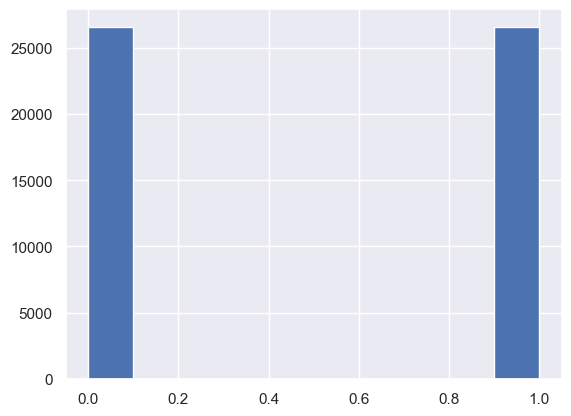

In [92]:
training_data_smote_nc['Outcome Type'].hist()